In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
df = pd.read_csv('datasets/detailed_meals_macros.csv')

In [61]:
df.head()

,Ages,Gender,Height,Weight,Activity Level,Dietary Preference,Daily Calorie Target,Protein,Sugar,Sodium,...,Dinner Protein.1,Dinner Carbohydrates.1,Dinner Fats,Snack Suggestion,Snacks Calories,Snacks Protein,Snacks Carbohydrates,Snacks Fats,Disease,Lunch Fats
0,25,Male,180,80,Moderately Active,Omnivore,2000,120,125.0,24.0,...,60.0,250.0,60.0,Greek yogurt with fruit,150,10,20,5,Weight Gain,12.0
1,32,Female,165,65,Lightly Active,Vegetarian,1600,80,100.0,16.0,...,5.0,31.0,27.0,Apple with almond butter,180,4,30,8,"Weight Gain, Hypertension, Heart Disease",8.0
2,48,Male,175,95,Sedentary,Vegan,2200,100,150.0,20.0,...,55.0,150.0,15.0,Trail mix,300,8,34,20,Weight Gain,15.0
3,55,Female,160,70,Very Active,Omnivore,2500,140,175.0,28.0,...,20.0,163.0,27.0,Banana with peanut butter,210,5,30,9,Weight Gain,10.0
4,62,Male,170,85,Sedentary,Vegetarian,2000,80,125.0,16.0,...,6.3,186.0,22.0,Fruit and nut mix,250,6,28,15,Weight Gain,9.0


In [62]:
trainer = pd.read_csv('datasets/data_to_train.csv')

In [63]:
df.columns

Index(['Ages', 'Gender', 'Height', 'Weight', 'Activity Level',
       'Dietary Preference', 'Daily Calorie Target', 'Protein', 'Sugar',
       'Sodium', 'Calories', 'Carbohydrates', 'Fiber', 'Fat',
       'Breakfast Suggestion', 'Breakfast Calories', 'Breakfast Protein',
       'Breakfast Carbohydrates', 'Breakfast Fats', 'Lunch Suggestion',
       'Lunch Calories', 'Lunch Protein', 'Lunch Carbohydrates',
       'Dinner Suggestion', 'Dinner Calories', 'Dinner Protein.1',
       'Dinner Carbohydrates.1', 'Dinner Fats', 'Snack Suggestion',
       'Snacks Calories', 'Snacks Protein', 'Snacks Carbohydrates',
       'Snacks Fats', 'Disease', 'Lunch Fats'],
      dtype='object')

In [64]:
import re

def clean_text(text):
    if isinstance(text, str) and text.strip():
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        return text.strip()
    else:
        return ""


trainer['Disease'] = trainer['Disease'].apply(clean_text)
df['Disease'] = df['Disease'].apply(clean_text)

In [65]:
df['Disease'] = df['Disease'].replace('Weight Gain', 'Overweight')

In [66]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Step 1: Clean and drop NaNs in df['Disease']
df = df.dropna(subset=['Disease'])
df['Disease'] = df['Disease'].astype(str)

# Step 2: Precompute embeddings for df diseases
df_embeddings = model.encode(df['Disease'].tolist(), convert_to_tensor=True)

# Step 3: Match function
def match_with_sbert(disease):
    emb = model.encode(disease, convert_to_tensor=True)
    scores = util.pytorch_cos_sim(emb, df_embeddings)[0]
    best_idx = scores.argmax().item()
    return best_idx, scores[best_idx].item()

# Step 4: Go through trainer diseases and get matches + merged info
matches = []

for disease in trainer['Disease']:
    if isinstance(disease, str) and disease.strip():
        idx, score = match_with_sbert(disease)
        row = df.iloc[idx]
        match_row = {
            'Trainer Disease': disease,
            'Matched Disease': row['Disease'],
            'Similarity Score': score
        }
        # Add all the other columns from df
        match_row.update(row.drop(labels=['Disease']).to_dict())
        matches.append(match_row)

# Step 5: Final merged dataframe
result_df = pd.DataFrame(matches)


In [67]:
result_df

,Trainer Disease,Matched Disease,Similarity Score,Ages,Gender,Height,Weight,Activity Level,Dietary Preference,Daily Calorie Target,...,Dinner Calories,Dinner Protein.1,Dinner Carbohydrates.1,Dinner Fats,Snack Suggestion,Snacks Calories,Snacks Protein,Snacks Carbohydrates,Snacks Fats,Lunch Fats
0,hypercholesterolemia low calcium intake low ir...,weight gain hypertension heart disease,0.423667,32,Female,165,65,Lightly Active,Vegetarian,1600,...,10.0,5.0,31.0,27.0,Apple with almond butter,180,4,30,8,8.0
1,stage hypertension hypercholesterolemia low ca...,weight gain hypertension heart disease,0.513300,32,Female,165,65,Lightly Active,Vegetarian,1600,...,10.0,5.0,31.0,27.0,Apple with almond butter,180,4,30,8,8.0
2,stage hypertension low calcium intake low iron...,weight gain hypertension heart disease,0.492331,32,Female,165,65,Lightly Active,Vegetarian,1600,...,10.0,5.0,31.0,27.0,Apple with almond butter,180,4,30,8,8.0
3,hypotension low calcium intake low iron intake...,weight gain hypertension heart disease,0.351282,32,Female,165,65,Lightly Active,Vegetarian,1600,...,10.0,5.0,31.0,27.0,Apple with almond butter,180,4,30,8,8.0
4,stage hypertension low calcium intake low iron...,weight gain hypertension heart disease,0.510877,32,Female,165,65,Lightly Active,Vegetarian,1600,...,10.0,5.0,31.0,27.0,Apple with almond butter,180,4,30,8,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8606,hypotension low calcium intake low iron intake...,weight gain hypertension heart disease,0.351282,32,Female,165,65,Lightly Active,Vegetarian,1600,...,10.0,5.0,31.0,27.0,Apple with almond butter,180,4,30,8,8.0
8607,stage hypertension hypercholesterolemia low ca...,weight gain hypertension heart disease,0.543249,32,Female,165,65,Lightly Active,Vegetarian,1600,...,10.0,5.0,31.0,27.0,Apple with almond butter,180,4,30,8,8.0
8608,stage hypertension hypercholesterolemia low ca...,weight gain hypertension heart disease,0.513300,32,Female,165,65,Lightly Active,Vegetarian,1600,...,10.0,5.0,31.0,27.0,Apple with almond butter,180,4,30,8,8.0
8609,stage hypertension hypercholesterolemia low ca...,weight gain hypertension heart disease,0.543249,32,Female,165,65,Lightly Active,Vegetarian,1600,...,10.0,5.0,31.0,27.0,Apple with almond butter,180,4,30,8,8.0


In [68]:
# List of nutrition columns to merge
cols_to_merge = [
    'Trainer Disease',  # needed for merging
    'Protein', 'Sugar', 'Sodium', 'Calories', 'Carbohydrates', 'Fiber', 'Fat',
    'Breakfast Suggestion', 'Breakfast Calories', 'Breakfast Protein',
    'Breakfast Carbohydrates', 'Breakfast Fats', 'Lunch Suggestion',
    'Lunch Calories', 'Lunch Protein', 'Lunch Carbohydrates', 'Dinner Suggestion',
    'Dinner Calories', 'Dinner Protein.1', 'Dinner Carbohydrates.1',
    'Dinner Fats', 'Snack Suggestion', 'Snacks Calories', 'Snacks Protein',
    'Snacks Carbohydrates', 'Snacks Fats', 'Lunch Fats'
]

# Step 1: Select only needed columns from result_df
result_subset = result_df[cols_to_merge].copy()

# Step 2: Ensure proper types for merge
trainer['Disease'] = trainer['Disease'].astype(str)
result_subset['Trainer Disease'] = result_subset['Trainer Disease'].astype(str)

# Step 3: Merge with trainer based on disease name
merged_trainer = trainer.merge(result_subset, how='left', left_on='Disease', right_on='Trainer Disease')

# Step 4: Drop 'Trainer Disease' (optional cleanup)
merged_trainer.drop(columns=['Trainer Disease'], inplace=True)


In [69]:
merged_trainer.drop(['Unnamed: 0', 'Snack Suggestion', 'Breakfast Suggestion', 'Lunch Suggestion', 'Dinner Suggestion'], axis=1, inplace=True)
merged_trainer.drop_duplicates(inplace=True)

In [70]:
merged_trainer.to_csv('datasets/final_model_dataset.csv', index=False)

In [71]:
df.columns

Index(['Ages', 'Gender', 'Height', 'Weight', 'Activity Level',
       'Dietary Preference', 'Daily Calorie Target', 'Protein', 'Sugar',
       'Sodium', 'Calories', 'Carbohydrates', 'Fiber', 'Fat',
       'Breakfast Suggestion', 'Breakfast Calories', 'Breakfast Protein',
       'Breakfast Carbohydrates', 'Breakfast Fats', 'Lunch Suggestion',
       'Lunch Calories', 'Lunch Protein', 'Lunch Carbohydrates',
       'Dinner Suggestion', 'Dinner Calories', 'Dinner Protein.1',
       'Dinner Carbohydrates.1', 'Dinner Fats', 'Snack Suggestion',
       'Snacks Calories', 'Snacks Protein', 'Snacks Carbohydrates',
       'Snacks Fats', 'Disease', 'Lunch Fats'],
      dtype='object')

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# ----------------------------
# Step 1: Encode target column
# ----------------------------
le = LabelEncoder()
df['Activity Level Encoded'] = le.fit_transform(df['Activity Level'])

# ----------------------------
# Step 2: Prepare features
# ----------------------------
X = df.drop(columns=['Activity Level', 'Activity Level Encoded'])
y = df['Activity Level Encoded']

# Encode categorical features
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = X[col].astype(str)
        X[col] = LabelEncoder().fit_transform(X[col])

# ----------------------------
# Step 3: Train Random Forest
# ----------------------------
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# ----------------------------
# Step 4: Get Top 4 Features
# ----------------------------
importances = model.feature_importances_
features = X.columns

feat_imp_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Only top 4
top_4_features = feat_imp_df.head(4)
print("Top 4 Features Influencing Activity Level:\n")
print(top_4_features)



Top 4 Features Influencing Activity Level:

                Feature  Importance
5  Daily Calorie Target    0.062055
3                Weight    0.055108
2                Height    0.048632
0                  Ages    0.047950


In [73]:
df.columns

Index(['Ages', 'Gender', 'Height', 'Weight', 'Activity Level',
       'Dietary Preference', 'Daily Calorie Target', 'Protein', 'Sugar',
       'Sodium', 'Calories', 'Carbohydrates', 'Fiber', 'Fat',
       'Breakfast Suggestion', 'Breakfast Calories', 'Breakfast Protein',
       'Breakfast Carbohydrates', 'Breakfast Fats', 'Lunch Suggestion',
       'Lunch Calories', 'Lunch Protein', 'Lunch Carbohydrates',
       'Dinner Suggestion', 'Dinner Calories', 'Dinner Protein.1',
       'Dinner Carbohydrates.1', 'Dinner Fats', 'Snack Suggestion',
       'Snacks Calories', 'Snacks Protein', 'Snacks Carbohydrates',
       'Snacks Fats', 'Disease', 'Lunch Fats', 'Activity Level Encoded'],
      dtype='object')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4893
[LightGBM] [Info] Number of data points in the train set: 1358, number of used features: 34
[LightGBM] [Info] Start training from score -2.434645
[LightGBM] [Info] Start training from score -1.480427
[LightGBM] [Info] Start training from score -1.396657
[LightGBM] [Info] Start training from score -1.433025
[LightGBM] [Info] Start training from score -1.615346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Top 4 Features:
               Feature  Importance
6              Protein         804
3               Weight         762
14  Breakfast Calories         762
0                 Ages         752


/tmp/ipykernel_11668/3212202068.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_features, palette='mako')


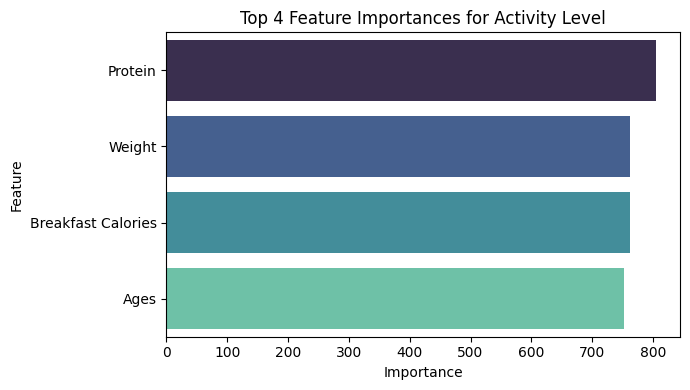

['Moderately Active']


In [74]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Copy original data
df_clean = df.copy()

# Step 2: Label encode the target column only
le_activity = LabelEncoder()
df_clean['Activity Level Encoded'] = le_activity.fit_transform(df_clean['Activity Level'])

# Step 3: Encode other categorical features
label_encoders = {}
for col in df_clean.columns:
    if df_clean[col].dtype == 'object' and col != 'Activity Level':
        le = LabelEncoder()
        df_clean[col] = le.fit_transform(df_clean[col].astype(str))
        label_encoders[col] = le

# Step 4: Normalize only features (not the target)
features = df_clean.drop(['Activity Level', 'Activity Level Encoded'], axis=1)
scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

y = df_clean['Activity Level Encoded']

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Train Classifier
model = LGBMClassifier()
model.fit(X_train, y_train)

# Step 7: Top 4 Features
importances = model.feature_importances_
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
top_features = feat_df.sort_values(by='Importance', ascending=False).head(4)
print("Top 4 Features:")
print(top_features)

# Step 8: Plot
plt.figure(figsize=(7, 4))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='mako')
plt.title("Top 4 Feature Importances for Activity Level")
plt.tight_layout()
plt.show()

# Step 9: Prediction Function
def predict_activity(new_data: pd.DataFrame):
    # Encode string columns
    for col in new_data.columns:
        if col in label_encoders:
            le = label_encoders[col]
            new_data[col] = new_data[col].map(lambda x: le.transform([str(x)])[0] if str(x) in le.classes_ else 0)
    # Scale
    new_data_scaled = pd.DataFrame(scaler.transform(new_data), columns=new_data.columns)
    # Predict
    pred = model.predict(new_data_scaled)
    return le_activity.inverse_transform(pred)

new_input = df.drop(columns=['Activity Level', 'Activity Level Encoded']).iloc[[0]]
print(predict_activity(new_input))


In [75]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier

# ---- Define correct feature names ----
features_df = ['Protein', 'Weight', 'Breakfast Calories', 'Ages']  # df column names
features_trainer = ['Protein', 'Body Weight (kg)', 'Breakfast Calories', 'Body Height (cm)']  # merged_trainer column names
target = 'Activity Level'

# ---- Clean and encode df ----
df_clean = df.dropna(subset=features_df + [target])
le = LabelEncoder()
df_clean['Activity Level Encoded'] = le.fit_transform(df_clean[target])

X = df_clean[features_df]
y = df_clean['Activity Level Encoded']

# ---- Train model ----
model = LGBMClassifier()
model.fit(X, y)

# ---- Predict on merged_trainer ----
merged_trainer_clean = merged_trainer.dropna(subset=features_trainer)
X_new = merged_trainer_clean[features_trainer]

preds = model.predict(X_new)
merged_trainer_clean['Predicted Activity Level'] = le.inverse_transform(preds)

# ---- Merge back into full merged_trainer ----
merged_trainer['Predicted Activity Level'] = merged_trainer_clean['Predicted Activity Level']

# ---- View Result ----
print(merged_trainer[['Body Weight (kg)', 'Protein', 'Breakfast Calories', 'Body Height (cm)', 'Predicted Activity Level']].head())


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 578
[LightGBM] [Info] Number of data points in the train set: 1698, number of used features: 4
[LightGBM] [Info] Start training from score -2.509953
[LightGBM] [Info] Start training from score -1.455792
[LightGBM] [Info] Start training from score -1.396952
[LightGBM] [Info] Start training from score -1.438270
[LightGBM] [Info] Start training from score -1.605324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
      Body Weight (kg)  Protein  Breakfast Calories  Body Height (cm)  \
0                 78.3     80.0               189.0             171.3   
799               89.5     80.0               189.0             176.8   
1226              88.9     80.0               189.0             175.3 

/tmp/ipykernel_11668/1816470152.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_trainer_clean['Predicted Activity Level'] = le.inverse_transform(preds)


In [76]:
merged_trainer_clean

,Body Mass Index (BMI),Body Weight (kg),Predicted Target Weight (kg),Body Height (cm),Predicted Time to Target (wks),Disease,Protein,Sugar,Sodium,Calories,...,Dinner Calories,Dinner Protein.1,Dinner Carbohydrates.1,Dinner Fats,Snacks Calories,Snacks Protein,Snacks Carbohydrates,Snacks Fats,Lunch Fats,Predicted Activity Level
0,26.7,78.3,64.580,171.3,26.642,hypercholesterolemia low calcium intake low ir...,80.0,100.0,16.0,1480.0,...,10.0,5.0,31.0,27.0,180.0,4.0,30.0,8.0,8.0,Sedentary
799,28.6,89.5,68.726,176.8,41.934,stage hypertension hypercholesterolemia low ca...,80.0,100.0,16.0,1480.0,...,10.0,5.0,31.0,27.0,180.0,4.0,30.0,8.0,8.0,Sedentary
1226,28.9,88.9,67.593,175.3,42.744,stage hypertension low calcium intake low iron...,80.0,100.0,16.0,1480.0,...,10.0,5.0,31.0,27.0,180.0,4.0,30.0,8.0,8.0,Sedentary
1493,17.1,32.2,49.592,137.3,10.540,hypotension low calcium intake low iron intake...,80.0,100.0,16.0,1480.0,...,10.0,5.0,31.0,27.0,180.0,4.0,30.0,8.0,8.0,Moderately Active
1802,19.7,52.0,58.685,162.4,8.784,stage hypertension low calcium intake low iron...,80.0,100.0,16.0,1480.0,...,10.0,5.0,31.0,27.0,180.0,4.0,30.0,8.0,8.0,Moderately Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4719511,24.5,71.8,64.339,171.3,15.808,hypotension low calcium intake low iron intake...,80.0,100.0,16.0,1480.0,...,10.0,5.0,31.0,27.0,180.0,4.0,30.0,8.0,8.0,Sedentary
4719820,15.9,11.3,49.592,84.4,10.540,stage hypertension hypercholesterolemia low ca...,80.0,100.0,16.0,1480.0,...,10.0,5.0,31.0,27.0,180.0,4.0,30.0,8.0,8.0,Moderately Active
4720173,34.0,89.6,57.449,162.3,53.776,stage hypertension hypercholesterolemia low ca...,80.0,100.0,16.0,1480.0,...,10.0,5.0,31.0,27.0,180.0,4.0,30.0,8.0,8.0,Sedentary
4720600,16.1,22.8,49.592,119.1,10.540,stage hypertension hypercholesterolemia low ca...,80.0,100.0,16.0,1480.0,...,10.0,5.0,31.0,27.0,180.0,4.0,30.0,8.0,8.0,Moderately Active
